In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/mnist', one_hot=True)

# MNIST Dataset Visualization

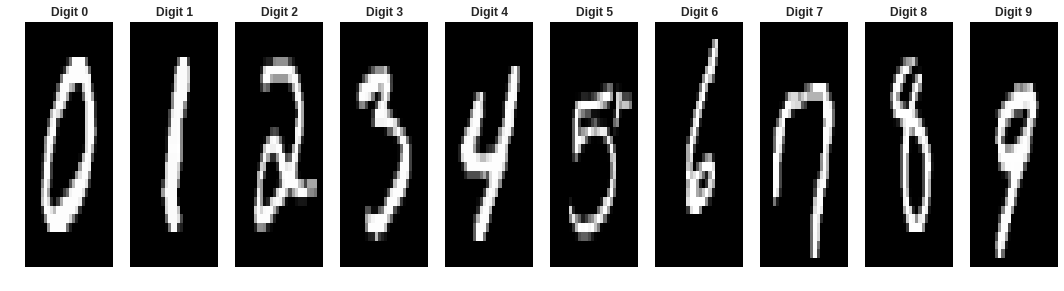

In [0]:
num_row, num_col = 1, 10
f,subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

X,y = mnist.train.images, mnist.train.labels
X = np.reshape(X,(-1,28,28))

for i in range(num_col):
    X_img = X[np.argmax(y,axis=1) == i].reshape((-1,28,28))
    idx = np.random.choice(np.arange(0, X_img.shape[0]))
    subplots[i].imshow(X_img[idx], cmap='gray', interpolation='nearest', aspect='auto')
    title = 'Digit {}'.format(i)
    subplots[i].set_title(title, fontweight="bold")
    subplots[i].grid(b=False)
    subplots[i].axis('off')

f.set_size_inches(18.5, 4.5)

# Solution

In [0]:
"""
Placeholders for input 
NB images are expressed in terms of vector and not matrices. 
"""
x = tf.placeholder(dtype=tf.float32, shape=[None, 784])  

# Placeholder for targets
targets = tf.placeholder(dtype=tf.float32, shape=[None, 10])

# Placeholder for discerning train/eval mode
is_training = tf.placeholder(dtype=tf.bool)

def inference(x, is_training, n_hidden=256):

  input_dim       = 784
  n_classes       = 10

  with tf.variable_scope('network'):
      x1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=tf.nn.relu)
      y = tf.contrib.layers.fully_connected(x1, n_classes, activation_fn=tf.nn.softmax)

      return y
    
def inference_with_dropout(x, is_training, n_hidden=256):

  input_dim       = 784
  n_classes       = 10
  keep_prob       = 0.7

  with tf.variable_scope('network'):
      x1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=tf.nn.relu)
      x1 = tf.contrib.layers.dropout(x1, is_training=is_training)
      y = tf.contrib.layers.fully_connected(x1, n_classes, activation_fn=tf.nn.softmax)
      return y
    
def inference_with_batch_normalization(x, is_training, n_hidden=256):

  input_dim       = 784
  n_classes       = 10

  with tf.variable_scope('network'):
      x1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=None)
      x1 = tf.layers.batch_normalization(x1, training=is_training)
      x1 = tf.nn.relu(x1)
      y = tf.contrib.layers.fully_connected(x1, n_classes, activation_fn=tf.nn.softmax)
      return y
    
# Define model output
y = inference_with_batch_normalization(x, is_training)

# Define metrics
correct_predictions = tf.equal(tf.argmax(y, axis=1), tf.argmax(targets, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Define loss function
loss = tf.reduce_mean(-tf.reduce_sum(targets * tf.log(y + np.finfo('float32').eps), axis=1))

# Training Procedure

In [0]:
with tf.Session() as sess:
    
    # Define train step using the AdamOptimizer
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
      
    init_op = tf.global_variables_initializer()

    # Initialize all variables
    sess.run(init_op)
    
    # Training parameters
    training_epochs = 15
    batch_size      = 128

    # Number of batches to process to see whole dataset
    batches_each_epoch = mnist.train.num_examples // batch_size

    for epoch in range(training_epochs):

        # During training measure accuracy on validation set to have an idea of what's happening
        val_accuracy = sess.run(fetches=accuracy,
                                feed_dict={x: mnist.validation.images, 
                                           targets: mnist.validation.labels,
                                           is_training: False})
        
        print('Epoch: {:06d} - VAL accuracy: {:.03f}'.format(epoch, val_accuracy))

        for _ in range(batches_each_epoch):

            # Load a batch of training data
            x_batch, target_batch = mnist.train.next_batch(batch_size)

            # Actually run one training step here
            sess.run(fetches=[train_step],
                     feed_dict={x: x_batch, targets: target_batch, is_training: True})

    test_accuracy = sess.run(fetches=accuracy,
                             feed_dict={x: mnist.test.images, 
                                        targets: mnist.test.labels, 
                                        is_training: False})
    print('*' * 50)
    print('Training ended. TEST accuracy: {:.03f}'.format(test_accuracy))